In [ ]:
!pip install xgboost shap nltk wordcloud


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import shap
import xgboost as xgb
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from statsmodels.multivariate.manova import MANOVA
from scipy.stats import mannwhitneyu, ttest_ind, chi2_contingency
import statsmodels.formula.api as smf

nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from google.colab import files
uploaded = files.upload()

# Replace the filename with yours
df = pd.read_csv("fake_news_dataset - 1.csv")

df['label'] = df['label'].map({'real': 0, 'fake': 1})
df.dropna(subset=['text'], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()


Saving fake_news_dataset - 1.csv to fake_news_dataset - 1 (2).csv


,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,0
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,1
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,1
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,1
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,1


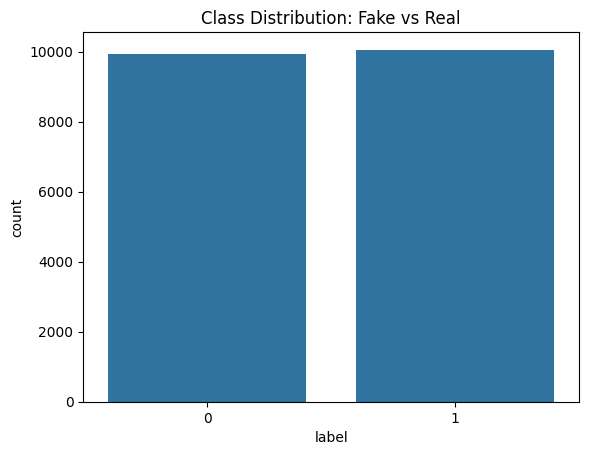

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.1+ MB
None
                                    title  \
count                               20000   
unique                              20000   
top     Get rich such leader can we hear.   
freq                                    1   
mean                                  NaN   
std                                   NaN   
min                                   NaN   
25%                                   NaN   
50%                                   NaN   
75%                                   NaN   


In [ ]:
# Class distribution
sns.countplot(data=df, x='label')
plt.title("Class Distribution: Fake vs Real")
plt.show()

# Print summary
print(df.info())
print(df.describe(include='all'))


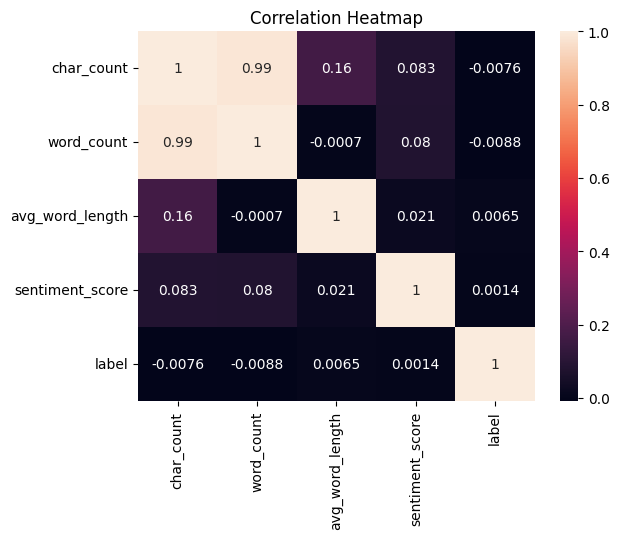

In [ ]:
df['char_count'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['text'].apply(lambda x: sum(len(w) for w in str(x).split()) / len(str(x).split()))

sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].apply(lambda x: sid.polarity_scores(str(x))['compound'])

# Correlation Heatmap
sns.heatmap(df[['char_count', 'word_count', 'avg_word_length', 'sentiment_score', 'label']].corr(), annot=True)
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(df['text'])

from scipy.sparse import hstack
X_meta = df[['char_count', 'word_count', 'avg_word_length', 'sentiment_score']].values
X = hstack([X_tfidf, X_meta])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("LASSO:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


LASSO:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      1971
           1       0.51      0.50      0.51      2029

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.50      4000
weighted avg       0.50      0.50      0.50      4000

Confusion Matrix:
 [[ 990  981]
 [1008 1021]]


SVM:
               precision    recall  f1-score   support

           0       0.50      0.70      0.58      1971
           1       0.51      0.30      0.38      2029

    accuracy                           0.50      4000
   macro avg       0.50      0.50      0.48      4000
weighted avg       0.50      0.50      0.48      4000



/tmp/ipython-input-10-121433174.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 600x400 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


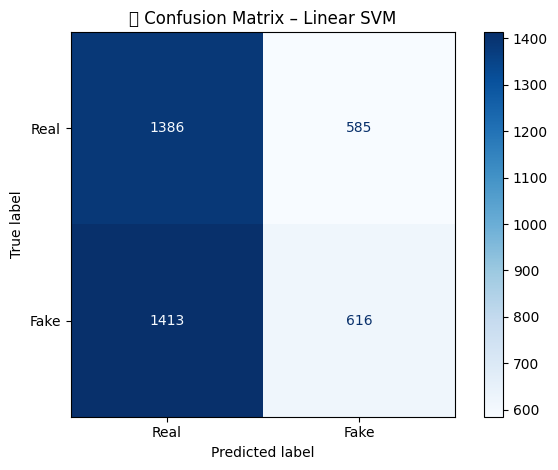

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train fast linear SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Print performance
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Display Confusion Matrix
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=["Real", "Fake"], cmap="Blues")
plt.title("📊 Confusion Matrix – Linear SVM")
plt.tight_layout()
plt.show()


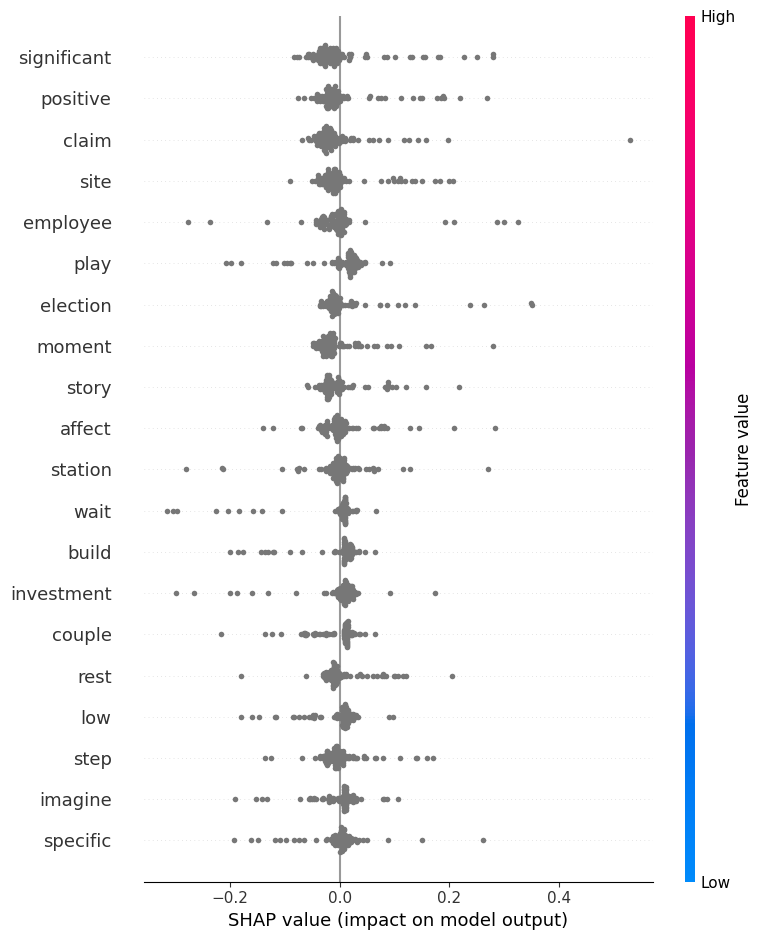

In [ ]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)

explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test[:100])

shap.summary_plot(shap_values, feature_names=vectorizer.get_feature_names_out().tolist() + ['char_count', 'word_count', 'avg_word_length', 'sentiment_score'])


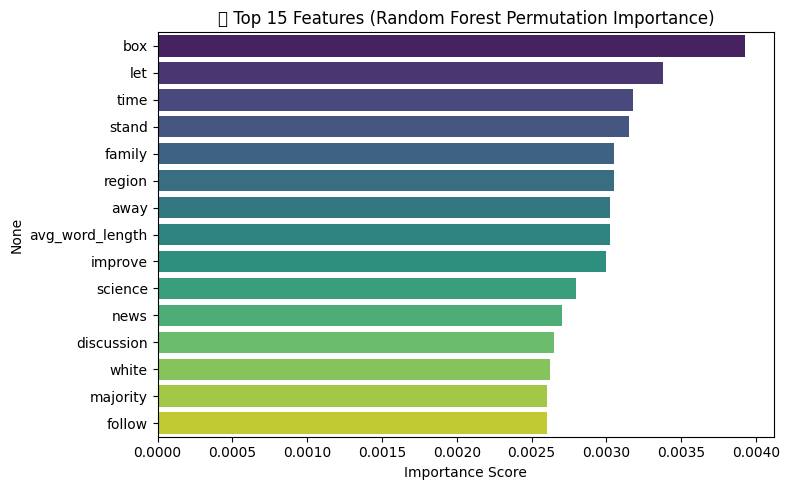

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Convert sparse matrix to dense for permutation importance
perm = permutation_importance(rf, X_test.toarray(), y_test, n_repeats=10, random_state=42)

features = vectorizer.get_feature_names_out().tolist() + ['char_count', 'word_count', 'avg_word_length', 'sentiment_score']
importances = pd.Series(perm.importances_mean, index=features)

top_features = importances.nlargest(15)
plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")
plt.title("🌳 Top 15 Features (Random Forest Permutation Importance)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



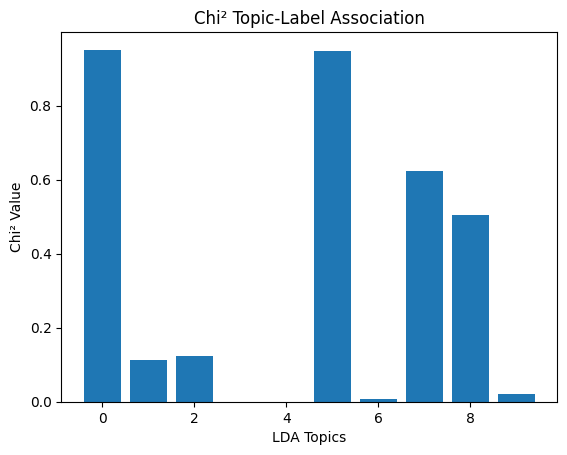

In [ ]:
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_lda = lda.fit_transform(X_tfidf)

from sklearn.feature_selection import chi2
chi2_val, _ = chi2(X_lda, y)

plt.bar(range(10), chi2_val)
plt.title("Chi² Topic-Label Association")
plt.xlabel("LDA Topics")
plt.ylabel("Chi² Value")
plt.show()


In [ ]:
# Step: PCA on TF-IDF
X_pca = PCA(n_components=5).fit_transform(X_tfidf.toarray())

# Convert to DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
pca_df['label'] = y.reset_index(drop=True)  # Make sure labels align

# Create MANOVA model
from statsmodels.multivariate.manova import MANOVA
manova = MANOVA.from_formula('PC1 + PC2 + PC3 + PC4 + PC5 ~ label', data=pca_df)

# Print MANOVA test results
print("MANOVA Result:")
print(manova.mv_test())


MANOVA Result:
                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF   Den DF   F Value Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.9998 5.0000 19994.0000  0.6044 0.6966
         Pillai's trace 0.0002 5.0000 19994.0000  0.6044 0.6966
 Hotelling-Lawley trace 0.0002 5.0000 19994.0000  0.6044 0.6966
    Roy's greatest root 0.0002 5.0000 19994.0000  0.6044 0.6966
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
         label          Value  Num DF   Den DF   F Value Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.9997 5.0000 19994.0000  1.2021 0.3052
         Pillai's trace 0.0003 5.0000 19994.

In [ ]:
df_small = df[['char_count', 'sentiment_score', 'label']]
model = smf.mixedlm("label ~ char_count + sentiment_score", df_small, groups=df_small.index)
result = model.fit()

print(result.summary())


          Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: label      
No. Observations:  20000   Method:             REML       
No. Groups:        20000   Scale:              0.1250     
Min. group size:   1       Log-Likelihood:     -14532.6293
Max. group size:   1       Converged:          Yes        
Mean group size:   1.0                                    
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        0.530    0.034 15.528 0.000  0.463  0.597
char_count      -0.000    0.000 -1.090 0.276 -0.000  0.000
sentiment_score  0.006    0.020  0.287 0.774 -0.033  0.044
Group Var        0.125                                    



In [ ]:
fake = df[df['label'] == 1]['sentiment_score']
real = df[df['label'] == 0]['sentiment_score']

print("Mann-Whitney U Test:", mannwhitneyu(fake, real))
print("Welch's t-test:", ttest_ind(fake, real, equal_var=False))


Mann-Whitney U Test: MannwhitneyuResult(statistic=np.float64(49989339.0), pvalue=np.float64(0.9822310770014473))
Welch's t-test: TtestResult(statistic=np.float64(0.19754218038070076), pvalue=np.float64(0.8434052861928514), df=np.float64(19978.531279732208))


In [ ]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

if 'source' in df.columns:
    cross_tab = pd.crosstab(df['source'], df['label'])
    print("Cramér’s V:", cramers_v(cross_tab.to_numpy()))


Cramér’s V: 0.012487236965553792


In [ ]:
from sklearn.cluster import KMeans
labels = KMeans(n_clusters=2, random_state=42).fit_predict(X_tfidf)
print("Silhouette Score:", silhouette_score(X_tfidf, labels))


Silhouette Score: 0.0011292261335311242


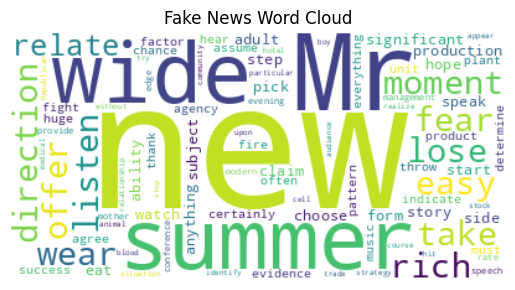

In [ ]:
text = " ".join(df[df['label'] == 1]['text'].astype(str))
wc = WordCloud(max_words=100, background_color='white').generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News Word Cloud")
plt.show()


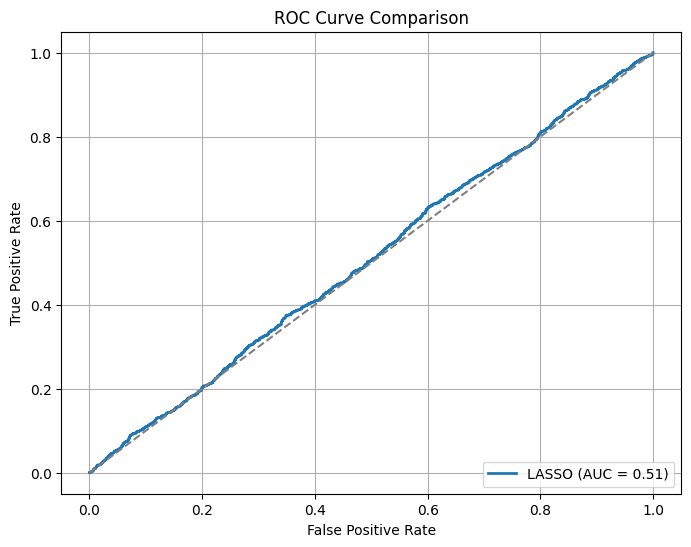

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ✅ Step 1: Define the model
lasso = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso.fit(X_train, y_train)

# ✅ Step 2: Define your ROC plotting function
def plot_roc(model, name):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# ✅ Step 3: Plot
plt.figure(figsize=(8,6))
plot_roc(lasso, 'LASSO')
# ...other models like SVM, XGBoost, etc.
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.grid()
plt.show()



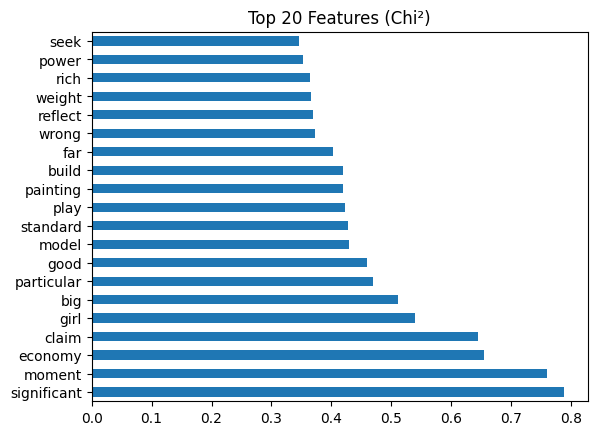

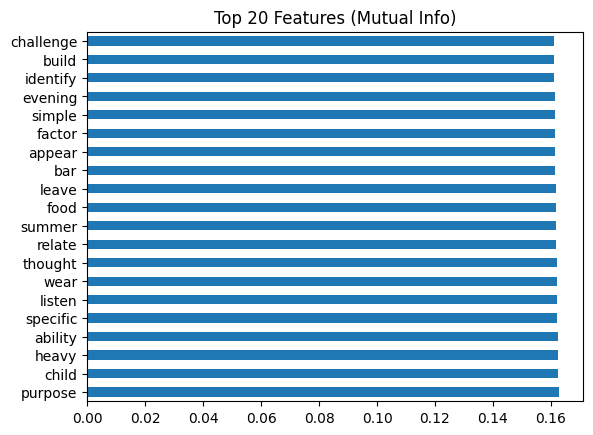

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Use TF-IDF only (no metadata)
X_fs = X_tfidf
y_fs = y

# Chi²
chi2_selector = SelectKBest(score_func=chi2, k=20)
chi2_selector.fit(X_fs, y_fs)
chi2_scores = pd.Series(chi2_selector.scores_, index=vectorizer.get_feature_names_out())
chi2_scores.nlargest(20).plot(kind='barh', title="Top 20 Features (Chi²)")
plt.show()

# Mutual Information
mi_selector = SelectKBest(score_func=mutual_info_classif, k=20)
mi_selector.fit(X_fs, y_fs)
mi_scores = pd.Series(mi_selector.scores_, index=vectorizer.get_feature_names_out())
mi_scores.nlargest(20).plot(kind='barh', title="Top 20 Features (Mutual Info)")
plt.show()
